### **Binary Classification: Pizza 🍕 vs Steak 🥩**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import pandas as pd
import math
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Input, MaxPool2D, Activation
from tensorflow.keras import Sequential

### **Exploring the Dataset**

In [ ]:
dataset_path = Path("/content/drive/MyDrive/Dataset/pizza_steak")

In [ ]:
def display_structure(path, indent=0):
    for item in sorted(path.iterdir()):
        if item.is_dir():
            print(' ' * indent + '└───' + item.name)
            display_structure(item, indent + 4)

print("Dataset Structure:")
display_structure(dataset_path)

Dataset Structure:
└───test
    └───pizza
    └───steak
└───train
    └───pizza
    └───steak


In [ ]:
train_path = dataset_path / "train"
test_path = dataset_path / "test"

**Image Count in Train and Test Folder**

In [ ]:
def count_images(path):
    counts = {}
    for subfolder in sorted(path.iterdir()):
        if subfolder.is_dir():
            counts[subfolder.name] = len(list(subfolder.glob("*.jpg")))
    return counts

train_counts = count_images(train_path)
test_counts = count_images(test_path)

print("Number of images in Train folder:", train_counts)
print("Number of images in Test folder:", test_counts)

Number of images in Train folder: {'pizza': 750, 'steak': 750}
Number of images in Test folder: {'pizza': 250, 'steak': 250}


**Visualizing Sample Images**

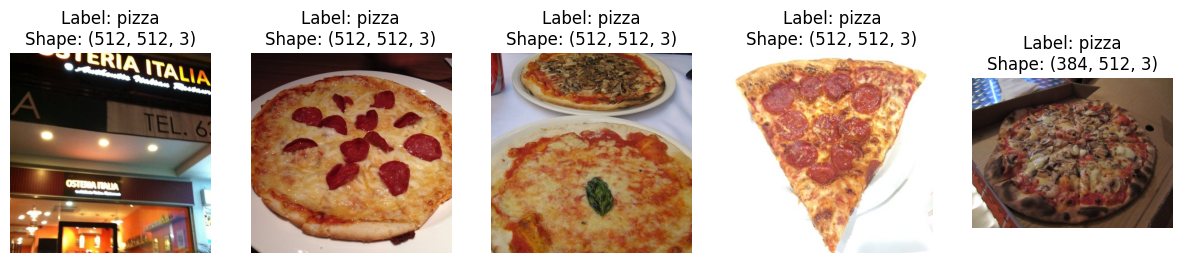

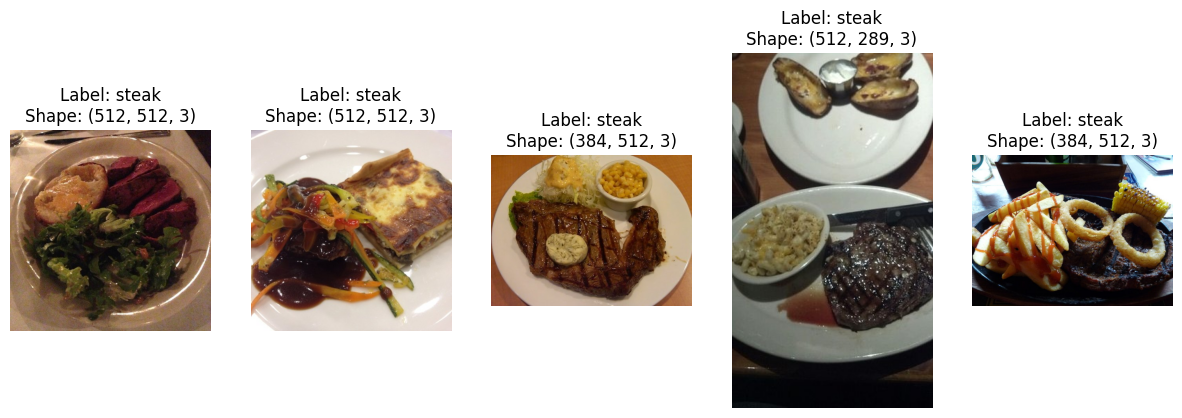

In [ ]:
def show_sample_images_with_labels_and_shape(class_name, folder_path, num_images=5):
    images = list(folder_path.glob(f"{class_name}/*.jpg"))
    random_images = random.sample(images, min(num_images, len(images)))

    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(random_images):
        img = mpimg.imread(img_path)
        img_shape = img.shape
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Label: {class_name}\nShape: {img_shape}")
    plt.show()

show_sample_images_with_labels_and_shape("pizza", train_path)
show_sample_images_with_labels_and_shape("steak", train_path)

**Checking Image Dimensions and Aspect Ratios**

In [ ]:
def check_image_dimensions(folder_path):
    dimensions = []
    for image_path in folder_path.glob("*/*.jpg"):
        with Image.open(image_path) as img:
            dimensions.append(img.size)
    return dimensions

train_dimensions = check_image_dimensions(train_path)

unique_dimensions = set(train_dimensions)
print("Unique dimensions in training set:", unique_dimensions)

Unique dimensions in training set: {(512, 342), (512, 461), (341, 512), (512, 287), (506, 512), (308, 512), (508, 512), (512, 354), (512, 308), (512, 366), (512, 436), (288, 512), (442, 512), (512, 384), (510, 512), (424, 512), (512, 509), (512, 262), (512, 512), (382, 512), (512, 332), (512, 396), (512, 442), (512, 341), (512, 344), (512, 289), (512, 304), (512, 307), (505, 512), (512, 432), (384, 512), (307, 512), (287, 512), (507, 512), (340, 512), (512, 499), (289, 512), (512, 383), (512, 511), (512, 343), (512, 340), (512, 407), (512, 465), (512, 471), (512, 410), (509, 512), (512, 288), (500, 512), (511, 512), (512, 306), (512, 486), (512, 364), (306, 512), (512, 434), (512, 254), (512, 318), (512, 382), (512, 388), (512, 446), (512, 385), (512, 333), (512, 339), (383, 512)}


**Checking for Class Imbalance**

       pizza  steak
Train    750    750
Test     250    250


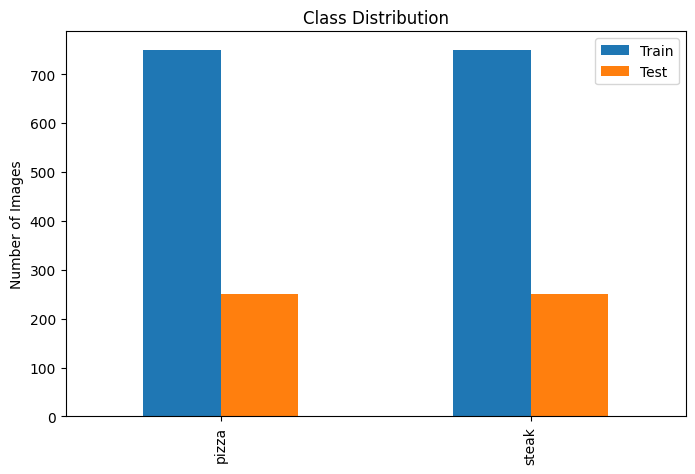

In [ ]:
def count_images_per_class(folder_path):
    counts = {}
    for subfolder in folder_path.iterdir():
        if subfolder.is_dir():
            counts[subfolder.name] = len(list(subfolder.glob("*.jpg")))
    return counts

train_counts = count_images_per_class(train_path)
test_counts = count_images_per_class(test_path)

df = pd.DataFrame([train_counts, test_counts], index=["Train", "Test"])
print(df)

df.T.plot(kind="bar", figsize=(8, 5), title="Class Distribution")
plt.ylabel("Number of Images")
plt.show()

### **Data for Training and Validation**

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_path,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary")

valid_data = valid_datagen.flow_from_directory(test_path,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary")

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [ ]:
images, labels = next(train_data)

print(f"Batch size: {len(images)}")
print(f"Image shape: {images[0].shape}")
print(f"Label shape: {labels.shape}")

Batch size: 32
Image shape: (224, 224, 3)
Label shape: (32,)


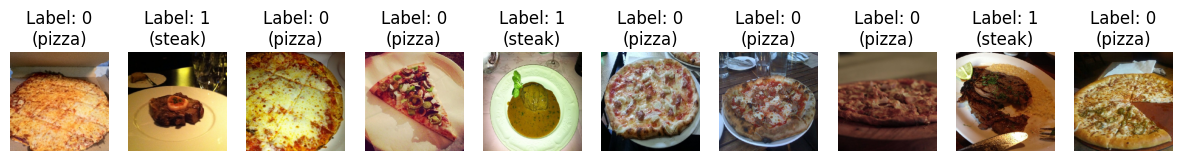

In [ ]:
def visualize_images_with_labels(images, labels, class_mapping, num_images=10):
    plt.figure(figsize=(15, 5))
    for i in range(min(num_images, len(images))):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.axis("off")
        label = int(labels[i])
        plt.title(f"Label: {label}\n({class_mapping[label]})")
    plt.show()

# Define the mapping for binary labels
class_mapping = {v: k for k, v in train_data.class_indices.items()}

# Visualize the first 10 images with their labels
visualize_images_with_labels(images, labels, class_mapping, num_images=10)

### **Model 1: Basic CNN Architecture**

🔹 **Expected Outcome:** Overfitting due to lack of pooling and feature extraction.

In [ ]:
tf.random.set_seed(42)

# CNN model (same as Tiny VGG)
model_1 = tf.keras.models.Sequential([
  Input(shape=(224, 224, 3)),
  Conv2D(filters=10,
         kernel_size=3,
         strides=1,
         padding='valid',
         activation='relu'),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  Flatten(),
  Dense(1, activation='sigmoid')
])

model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_1 = model_1.fit(train_data,
                        epochs=5,
                        validation_data=valid_data)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/47 ━━━━━━━━━━━━━━━━━━━━ 553s 11s/step - accuracy: 0.5553 - loss: 0.9068 - val_accuracy: 0.8360 - val_loss: 0.4006
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 212ms/step - accuracy: 0.8256 - loss: 0.4068 - val_accuracy: 0.8160 - val_loss: 0.3960
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 210ms/step - accuracy: 0.8734 - loss: 0.3210 - val_accuracy: 0.8420 - val_loss: 0.3678
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 196ms/step - accuracy: 0.9316 - loss: 0.1948 - val_accuracy: 0.8460 - val_loss: 0.3878
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 216ms/step - accuracy: 0.9809 - loss: 0.0873 - val_accuracy: 0.8240 - val_loss: 0.4106


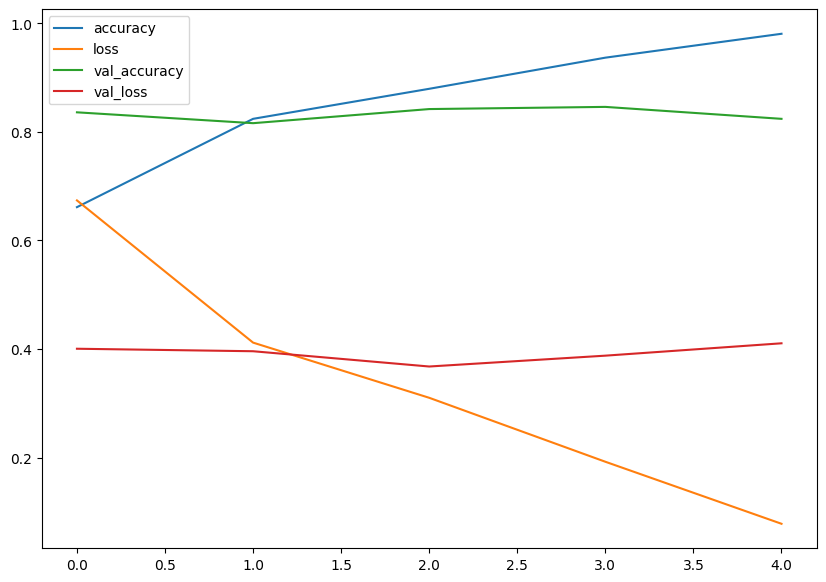

In [ ]:
pd.DataFrame(history_1.history).plot(figsize=(10, 7));

In [ ]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

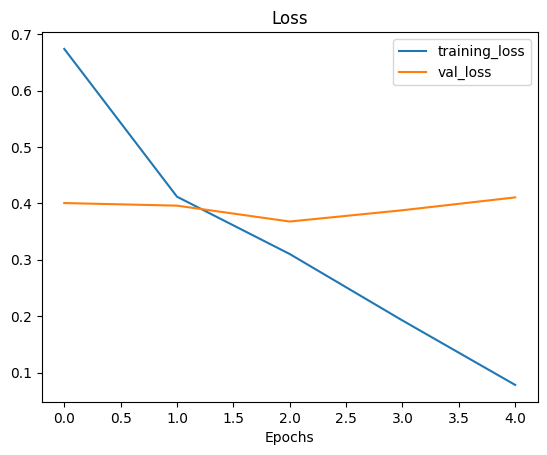

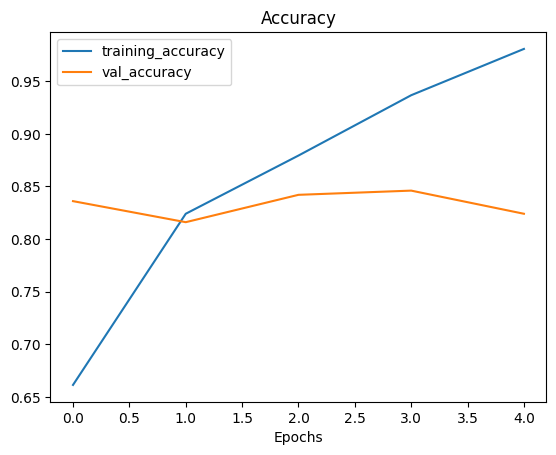

In [ ]:
plot_loss_curves(history_1)

In [ ]:
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 10)        │             280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 220, 220, 10)        │             910 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 218, 218, 10)        │             910 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 475240)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │         475,241 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,432,025 (5.46 MB)

 Trainable params: 477,341 (1.82 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 954,684 (3.64 MB)

### **Model 2: Adding Max Pooling for Feature Extraction**

🔹 **Expected Outcome:** Better generalization compared to Model 1.

In [ ]:
model_2 = Sequential([
  Input(shape=(224, 224, 3)),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(pool_size=2),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

model_2.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

history_2 = model_2.fit(train_data,
                        epochs=5,
                        validation_data=valid_data)

Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 264ms/step - accuracy: 0.5819 - loss: 0.6625 - val_accuracy: 0.7760 - val_loss: 0.4543
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 17s 208ms/step - accuracy: 0.7784 - loss: 0.4764 - val_accuracy: 0.8280 - val_loss: 0.4120
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 205ms/step - accuracy: 0.8165 - loss: 0.4230 - val_accuracy: 0.8300 - val_loss: 0.3570
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 198ms/step - accuracy: 0.8278 - loss: 0.3965 - val_accuracy: 0.8660 - val_loss: 0.3379
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 206ms/step - accuracy: 0.8228 - loss: 0.3767 - val_accuracy: 0.8460 - val_loss: 0.3396


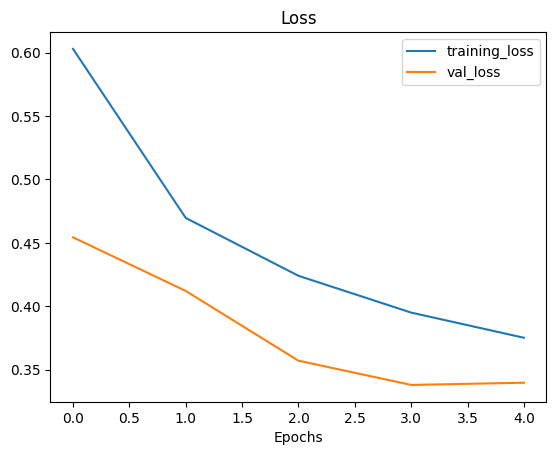

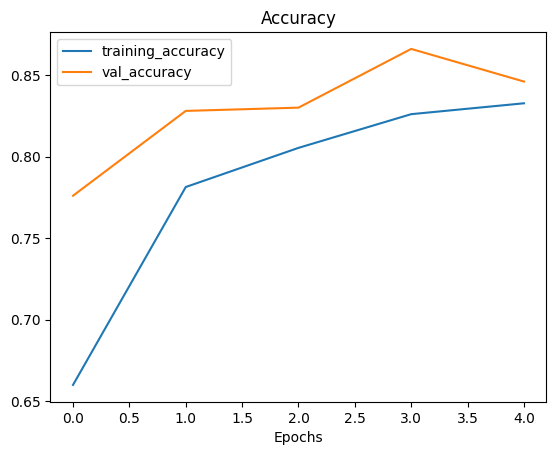

In [ ]:
plot_loss_curves(history_2)

In [ ]:
model_2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 222, 222, 10)        │             280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 10)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 109, 109, 10)        │             910 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 10)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 52, 52, 10)          │             910 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 26, 26, 10)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 6760)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │           6,761 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,585 (103.85 KB)

 Trainable params: 8,861 (34.61 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,724 (69.24 KB)

### **Model 3: Data Augmentation for Robustness**

🔹 **Expected Outcome:**

1.   Better performance on unseen data due to exposure to augmented samples.
2.   Reduced overfitting compared to previous models.

In [ ]:
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # rotate the image slightly between 0 and 20 degrees
                                             shear_range=0.2, # shear the image
                                             zoom_range=0.2, # zoom into the image
                                             width_shift_range=0.2, # shift the image width ways
                                             height_shift_range=0.2, # shift the image height ways
                                             horizontal_flip=True) # flip the image on the horizontal axis

# Create ImageDataGenerator training instance without data augmentation
train_datagen = ImageDataGenerator(rescale=1/255.)

# Create ImageDataGenerator test instance without data augmentation
test_datagen = ImageDataGenerator(rescale=1/255.)

In [ ]:
print("Augmented training images:")
train_data_augmented = train_datagen_augmented.flow_from_directory(train_path,
                                                                   target_size=(224, 224),
                                                                   batch_size=32,
                                                                   class_mode='binary',
                                                                   shuffle=False) # Don't shuffle for demonstration purposes, usually a good thing to shuffle

print("Non-augmented training images:")
train_data = train_datagen.flow_from_directory(train_path,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='binary',
                                               shuffle=False) # Don't shuffle for demonstration purposes

print("Unchanged test images:")
test_data = test_datagen.flow_from_directory(test_path,
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode='binary')

Augmented training images:
Found 1500 images belonging to 2 classes.
Non-augmented training images:
Found 1500 images belonging to 2 classes.
Unchanged test images:
Found 500 images belonging to 2 classes.


In [ ]:
images, labels = next(train_data)
augmented_images, augmented_labels = next(train_data_augmented)

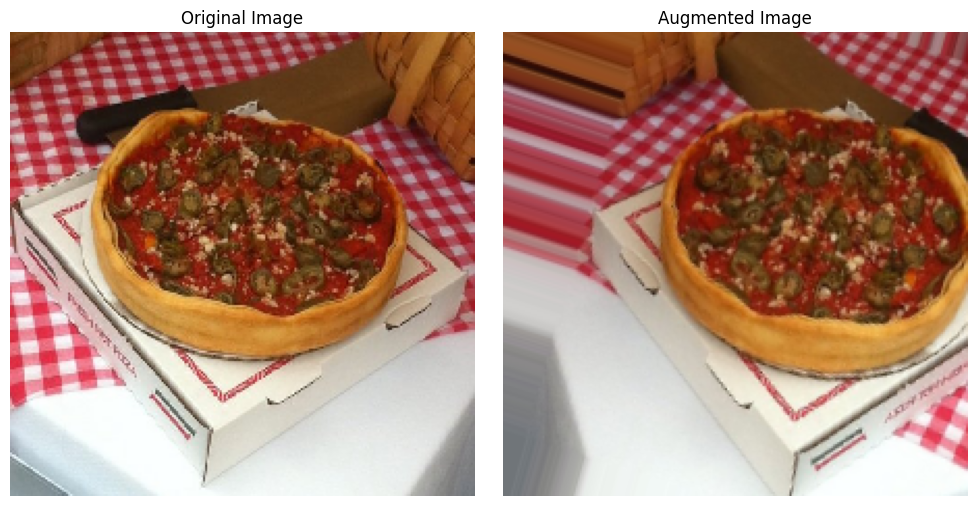

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

random_number = random.randint(0, len(images) - 1)

axes[0].imshow(images[random_number])
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(augmented_images[random_number])
axes[1].set_title("Augmented Image")
axes[1].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
model_3 = Sequential([
  Input(shape=(224, 224, 3)),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(pool_size=2),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_3.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

history_3 = model_3.fit(train_data_augmented,
                        epochs=5,
                        validation_data=test_data)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/47 ━━━━━━━━━━━━━━━━━━━━ 31s 545ms/step - accuracy: 0.4835 - loss: 0.7692 - val_accuracy: 0.5000 - val_loss: 0.6750
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 27s 506ms/step - accuracy: 0.5629 - loss: 0.6784 - val_accuracy: 0.6660 - val_loss: 0.6195
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 40s 491ms/step - accuracy: 0.6149 - loss: 0.6615 - val_accuracy: 0.6320 - val_loss: 0.5767
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 26s 482ms/step - accuracy: 0.6420 - loss: 0.6367 - val_accuracy: 0.7580 - val_loss: 0.5152
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 41s 481ms/step - accuracy: 0.7603 - loss: 0.5234 - val_accuracy: 0.7780 - val_loss: 0.4837


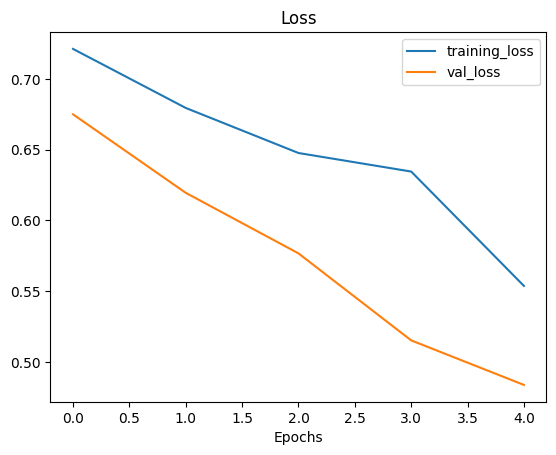

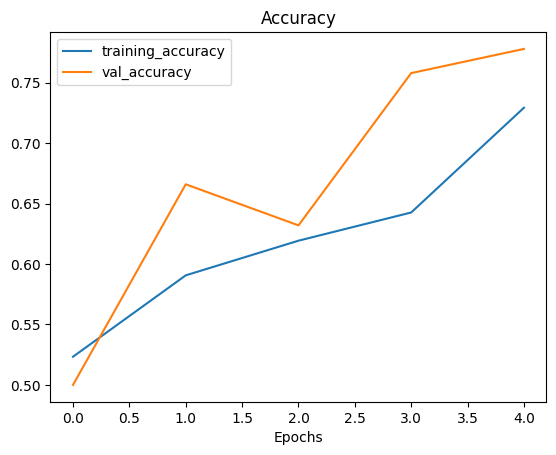

In [ ]:
plot_loss_curves(history_3)

### **Model 4: Shuffling Augmented Data for Better Learning**
🔹 **Expected Outcome:** Slight improvement in validation accuracy compared to Model 3.

In [ ]:
train_data_augmented_shuffled = train_datagen_augmented.flow_from_directory(train_path,
                                                                            target_size=(224, 224),
                                                                            batch_size=32,
                                                                            class_mode='binary',
                                                                            shuffle=True)

Found 1500 images belonging to 2 classes.


In [ ]:
model_4 = Sequential([
  Input(shape=(224, 224, 3)),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

model_4.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

history_4 = model_4.fit(train_data_augmented_shuffled,
                        epochs=5,
                        validation_data=test_data)

Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 29s 501ms/step - accuracy: 0.5583 - loss: 0.6881 - val_accuracy: 0.7300 - val_loss: 0.5269
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 26s 488ms/step - accuracy: 0.7279 - loss: 0.5737 - val_accuracy: 0.8300 - val_loss: 0.4148
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 41s 487ms/step - accuracy: 0.7892 - loss: 0.4872 - val_accuracy: 0.8260 - val_loss: 0.3933
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 26s 487ms/step - accuracy: 0.7869 - loss: 0.4690 - val_accuracy: 0.8520 - val_loss: 0.3514
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 25s 477ms/step - accuracy: 0.8118 - loss: 0.4539 - val_accuracy: 0.8700 - val_loss: 0.3236


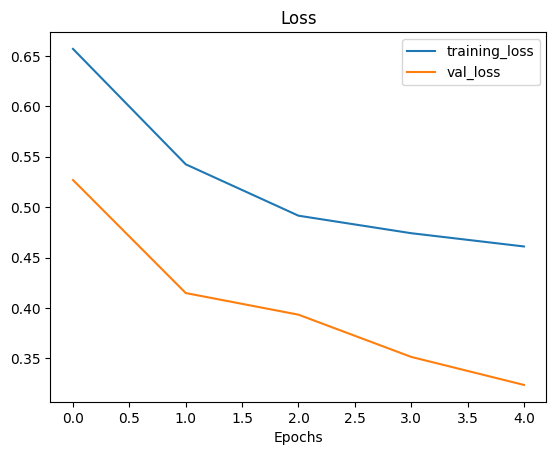

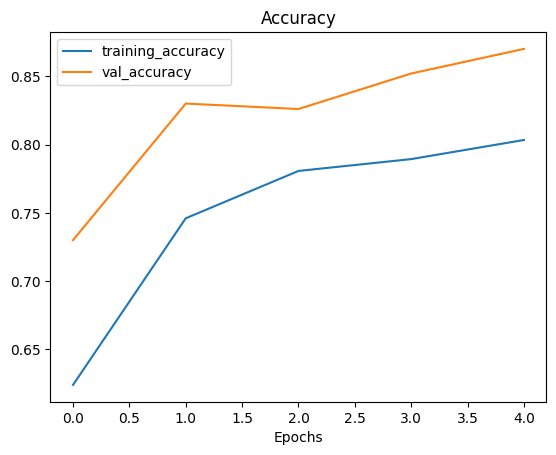

In [ ]:
plot_loss_curves(history_4)

### **Model 5: TinyVGG-Inspired Architecture**

In [ ]:
# TinyVGG model
model_5 = Sequential([
  Input(shape=(224, 224, 3)),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_5 = model_5.fit(train_data_augmented_shuffled,
                        epochs=5,
                        validation_data=test_data)

Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 32s 543ms/step - accuracy: 0.5162 - loss: 0.6842 - val_accuracy: 0.7420 - val_loss: 0.5533
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 37s 502ms/step - accuracy: 0.6890 - loss: 0.5873 - val_accuracy: 0.7920 - val_loss: 0.4887
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 41s 496ms/step - accuracy: 0.7343 - loss: 0.5603 - val_accuracy: 0.8480 - val_loss: 0.4017
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 26s 484ms/step - accuracy: 0.7381 - loss: 0.5245 - val_accuracy: 0.8620 - val_loss: 0.3659
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 41s 488ms/step - accuracy: 0.7712 - loss: 0.4896 - val_accuracy: 0.8560 - val_loss: 0.3723


In [ ]:
model_5.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 222, 222, 10)        │             280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 220, 220, 10)        │             910 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 110, 110, 10)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 108, 108, 10)        │             910 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 106, 106, 10)        │             910 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 53, 53, 10)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 28090)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │          28,091 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 93,305 (364.48 KB)

 Trainable params: 31,101 (121.49 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 62,204 (242.99 KB)

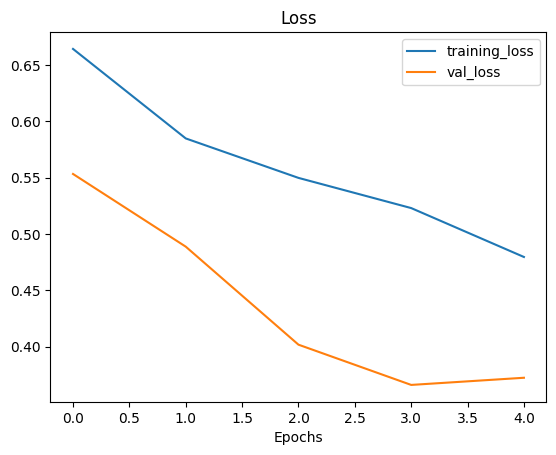

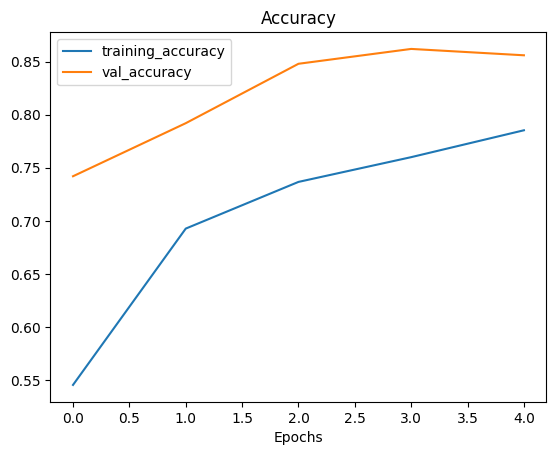

In [ ]:
plot_loss_curves(history_5)

### **Making a prediction with our trained model**

--2025-01-28 14:44:43--  https://ichef.bbci.co.uk/food/ic/food_16x9_1600/recipes/rib-eye_steak_with_61963_16x9.jpg
Resolving ichef.bbci.co.uk (ichef.bbci.co.uk)... 23.45.188.146, 2600:1409:8800:394::f33, 2600:1409:8800:381::f33, ...
Connecting to ichef.bbci.co.uk (ichef.bbci.co.uk)|23.45.188.146|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 293093 (286K) [image/jpeg]
Saving to: ‘rib-eye_steak_with_61963_16x9.jpg’

rib-eye_steak_with_ 100%[===================>] 286.22K  --.-KB/s    in 0.04s   

2025-01-28 14:44:43 (6.61 MB/s) - ‘rib-eye_steak_with_61963_16x9.jpg’ saved [293093/293093]



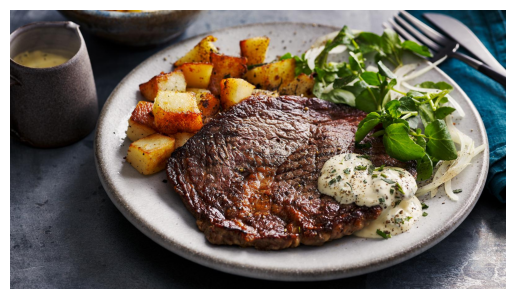

In [ ]:
!wget https://ichef.bbci.co.uk/food/ic/food_16x9_1600/recipes/rib-eye_steak_with_61963_16x9.jpg
steak = mpimg.imread("rib-eye_steak_with_61963_16x9.jpg")
plt.imshow(steak)
plt.axis(False);

In [ ]:
steak.shape

(900, 1600, 3)

In [ ]:
def load_and_prep_image(filename, img_shape=224):
  img = tf.io.read_file(filename)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.resize(img, size = [img_shape, img_shape])
  img = img/255.
  return img

In [ ]:
steak = load_and_prep_image("rib-eye_steak_with_61963_16x9.jpg")

In [ ]:
print(f"Shape before new dimension: {steak.shape}")
steak = tf.expand_dims(steak, axis=0)
print(f"Shape after new dimension: {steak.shape}")

Shape before new dimension: (224, 224, 3)
Shape after new dimension: (1, 224, 224, 3)


In [ ]:
pred = model_5.predict(steak)
pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


array([[0.8846212]], dtype=float32)

In [ ]:
class_names = ["pizza", "steak"]
pred_class = class_names[int(tf.round(pred)[0][0])]
pred_class

'steak'

In [ ]:
def pred_and_plot(model, filename, class_names):
  img = load_and_prep_image(filename)
  pred = model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[int(tf.round(pred)[0][0])]

  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


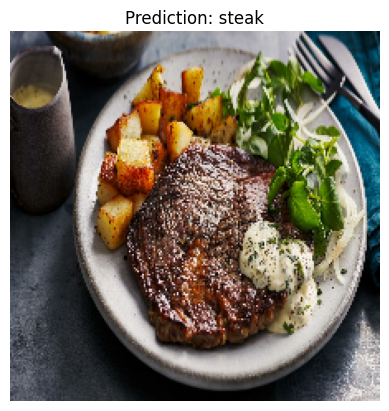

In [ ]:
pred_and_plot(model_5, "rib-eye_steak_with_61963_16x9.jpg", class_names)

--2025-01-28 14:48:50--  https://www.cobsbread.com/wp-content/uploads/2022/09/Pepperoni-pizza-850x630-1-585x400-1.jpg
Resolving www.cobsbread.com (www.cobsbread.com)... 104.21.69.48, 172.67.204.89
Connecting to www.cobsbread.com (www.cobsbread.com)|104.21.69.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78425 (77K) [image/jpeg]
Saving to: ‘Pepperoni-pizza-850x630-1-585x400-1.jpg’

Pepperoni-pizza-850 100%[===================>]  76.59K  --.-KB/s    in 0.01s   

2025-01-28 14:48:50 (5.02 MB/s) - ‘Pepperoni-pizza-850x630-1-585x400-1.jpg’ saved [78425/78425]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


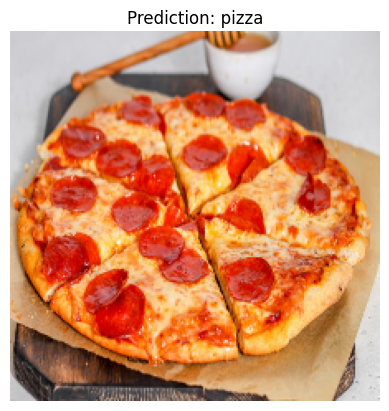

In [ ]:
!wget https://www.cobsbread.com/wp-content/uploads/2022/09/Pepperoni-pizza-850x630-1-585x400-1.jpg
pred_and_plot(model_5, "Pepperoni-pizza-850x630-1-585x400-1.jpg", class_names)

### **Multiclass Classification: Classifying 10 Food Categories 🍗🍣🍔🍕**

In [ ]:
dataset_path = Path("/content/drive/MyDrive/Dataset/10_food_classes")

train_path = dataset_path / "train"
test_path = dataset_path / "test"

### **Dataset Exploration**

In [ ]:
def display_structure(path, indent=0):
    for item in sorted(path.iterdir()):
        if item.is_dir():
            print(' ' * indent + '└───' + item.name)
            display_structure(item, indent + 4)

print("Dataset Structure:")
display_structure(dataset_path)

Dataset Structure:
└───test
    └───chicken_curry
    └───chicken_wings
    └───fried_rice
    └───grilled_salmon
    └───hamburger
    └───ice_cream
    └───pizza
    └───ramen
    └───steak
    └───sushi
└───train
    └───chicken_curry
    └───chicken_wings
    └───fried_rice
    └───grilled_salmon
    └───hamburger
    └───ice_cream
    └───pizza
    └───ramen
    └───steak
    └───sushi


In [ ]:
def count_images(path):
    counts = {}
    for subfolder in sorted(path.iterdir()):
        if subfolder.is_dir():
            counts[subfolder.name] = len(list(subfolder.glob("*.jpg")))
    return counts

train_counts = count_images(train_path)
test_counts = count_images(test_path)

print("Number of images in Train folder:", train_counts)
print("Number of images in Test folder:", test_counts)

Number of images in Train folder: {'chicken_curry': 750, 'chicken_wings': 750, 'fried_rice': 750, 'grilled_salmon': 750, 'hamburger': 750, 'ice_cream': 750, 'pizza': 750, 'ramen': 750, 'steak': 750, 'sushi': 750}
Number of images in Test folder: {'chicken_curry': 250, 'chicken_wings': 250, 'fried_rice': 250, 'grilled_salmon': 250, 'hamburger': 250, 'ice_cream': 250, 'pizza': 250, 'ramen': 250, 'steak': 250, 'sushi': 250}


In [ ]:
def show_sample_images_with_labels_and_shape(class_name, folder_path, num_images=5):
    images = list(folder_path.glob(f"{class_name}/*.jpg"))
    random_images = random.sample(images, min(num_images, len(images)))

    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(random_images):
        img = mpimg.imread(img_path)
        img_shape = img.shape
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Label: {class_name}\nShape: {img_shape}")
    plt.show()

show_sample_images_with_labels_and_shape("chicken_curry", train_path)
show_sample_images_with_labels_and_shape("chicken_wings", train_path)
show_sample_images_with_labels_and_shape("fried_rice", train_path)
show_sample_images_with_labels_and_shape("grilled_salmon", train_path)
show_sample_images_with_labels_and_shape("hamburger", train_path)
show_sample_images_with_labels_and_shape("ice_cream", train_path)
show_sample_images_with_labels_and_shape("pizza", train_path)
show_sample_images_with_labels_and_shape("ramen", train_path)
show_sample_images_with_labels_and_shape("steak", train_path)
show_sample_images_with_labels_and_shape("sushi", train_path)

Output hidden; open in https://colab.research.google.com to view.

       pizza  sushi  chicken_wings  ramen  steak  ice_cream  hamburger  \
Train    750    750            750    750    750        750        750   
Test     250    250            250    250    250        250        250   

       chicken_curry  fried_rice  grilled_salmon  
Train            750         750             750  
Test             250         250             250  


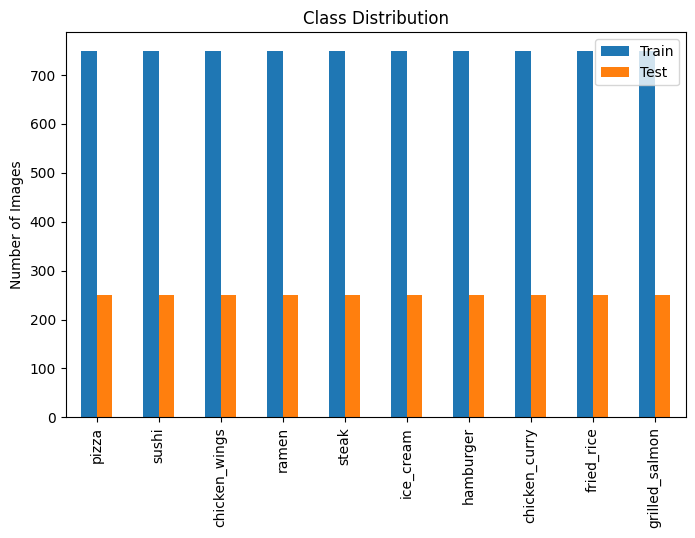

In [ ]:
def count_images_per_class(folder_path):
    counts = {}
    for subfolder in folder_path.iterdir():
        if subfolder.is_dir():
            counts[subfolder.name] = len(list(subfolder.glob("*.jpg")))
    return counts

train_counts = count_images_per_class(train_path)
test_counts = count_images_per_class(test_path)

df = pd.DataFrame([train_counts, test_counts], index=["Train", "Test"])
print(df)

df.T.plot(kind="bar", figsize=(8, 5), title="Class Distribution")
plt.ylabel("Number of Images")
plt.show()

### **🔹 Model 6: Basic Convolutional Neural Network (CNN)**

📌 **Issues:**

1.   Overfitting: The training accuracy is high, but the validation accuracy is very low.
2.   High validation loss: Model struggles to generalize to unseen data.

In [ ]:
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Load data in from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_path,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='categorical')

test_data = train_datagen.flow_from_directory(test_path,
                                              target_size=(224, 224),
                                              batch_size=32,
                                              class_mode='categorical')

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [ ]:
model_6 = Sequential([
  Input(shape=(224, 224, 3)),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(10, activation='softmax')
])

model_6.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_6 = model_6.fit(train_data,
                        epochs=5,
                        validation_data=test_data)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


235/235 ━━━━━━━━━━━━━━━━━━━━ 4636s 19s/step - accuracy: 0.1536 - loss: 2.2460 - val_accuracy: 0.2268 - val_loss: 2.0841
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 63s 262ms/step - accuracy: 0.2722 - loss: 2.0300 - val_accuracy: 0.2684 - val_loss: 2.0150
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 55s 230ms/step - accuracy: 0.4285 - loss: 1.6627 - val_accuracy: 0.2844 - val_loss: 2.0607
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 54s 227ms/step - accuracy: 0.6909 - loss: 0.9705 - val_accuracy: 0.2660 - val_loss: 2.6772
Epoch 5/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 82s 227ms/step - accuracy: 0.8904 - loss: 0.3719 - val_accuracy: 0.2552 - val_loss: 4.0349


In [ ]:
model_6.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 172ms/step - accuracy: 0.2563 - loss: 4.0748


[4.034862995147705, 0.25519999861717224]

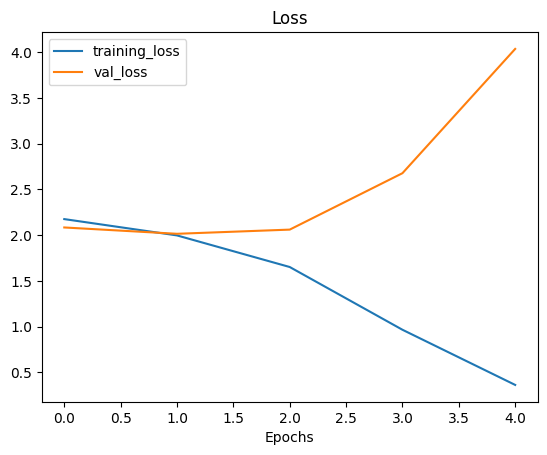

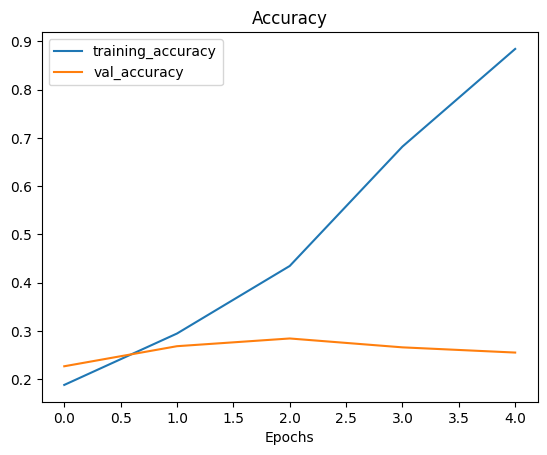

In [ ]:
plot_loss_curves(history_6)

### **🔹 Model 7: Simplified CNN with Fewer Parameters**

📌 **Key Observations:**

1.   The model improved validation accuracy slightly.
2.   Still some overfitting

In [ ]:
model_7 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(10, activation='softmax')
])

model_7.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

history_7 = model_7.fit(train_data,
                        epochs=5,
                        validation_data=test_data)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 66s 263ms/step - accuracy: 0.2158 - loss: 2.1913 - val_accuracy: 0.3200 - val_loss: 1.9196
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 79s 257ms/step - accuracy: 0.4040 - loss: 1.7713 - val_accuracy: 0.3632 - val_loss: 1.8151
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 75s 227ms/step - accuracy: 0.5458 - loss: 1.4048 - val_accuracy: 0.3456 - val_loss: 1.8891
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 62s 257ms/step - accuracy: 0.7378 - loss: 0.8849 - val_accuracy: 0.3420 - val_loss: 2.0843
Epoch 5/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 82s 259ms/step - accuracy: 0.8919 - loss: 0.4475 - val_accuracy: 0.3204 - val_loss: 2.5163


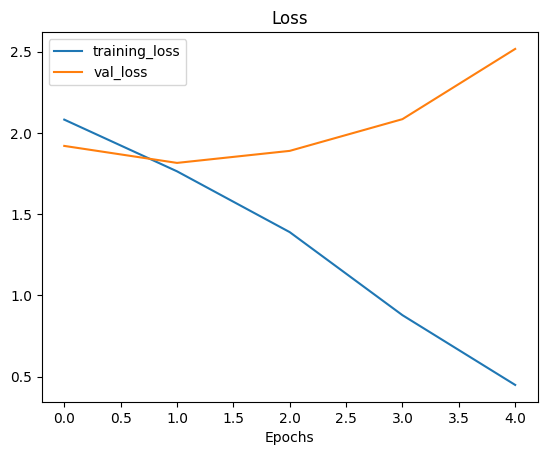

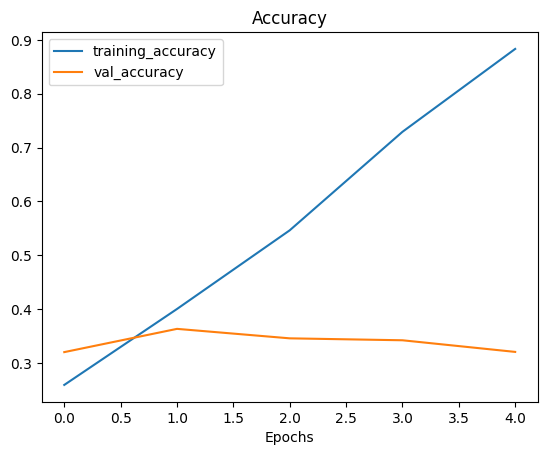

In [ ]:
plot_loss_curves(history_7)

### **🔹 Model 8: Simplified CNN with Data Augmentation**


1.   Best generalization so far—data augmentation prevents the model from memorizing training images.
2.   Validation accuracy is highest (37.16%) among all models.
3.   Model is less overfitted compared to previous versions.


In [ ]:
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20,
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             zoom_range=0.2,
                                             horizontal_flip=True)

train_data_augmented = train_datagen_augmented.flow_from_directory(train_path,
                                                                  target_size=(224, 224),
                                                                  batch_size=32,
                                                                  class_mode='categorical')

Found 7500 images belonging to 10 classes.


In [ ]:
model_8 = tf.keras.models.clone_model(model_7)

model_8.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_8 = model_8.fit(train_data_augmented,
                         epochs=5,
                         validation_data=test_data)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


235/235 ━━━━━━━━━━━━━━━━━━━━ 135s 551ms/step - accuracy: 0.1411 - loss: 2.3358 - val_accuracy: 0.2392 - val_loss: 2.0762
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 137s 564ms/step - accuracy: 0.2307 - loss: 2.1229 - val_accuracy: 0.2948 - val_loss: 2.0039
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 139s 550ms/step - accuracy: 0.2609 - loss: 2.0656 - val_accuracy: 0.3172 - val_loss: 1.9580
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 139s 580ms/step - accuracy: 0.2997 - loss: 1.9996 - val_accuracy: 0.3720 - val_loss: 1.8501
Epoch 5/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 145s 604ms/step - accuracy: 0.3232 - loss: 1.9746 - val_accuracy: 0.3716 - val_loss: 1.8318


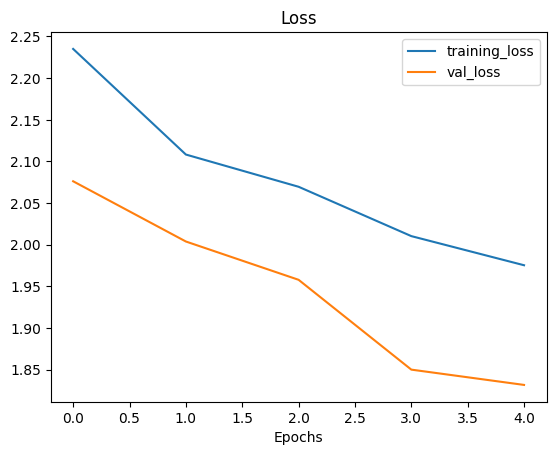

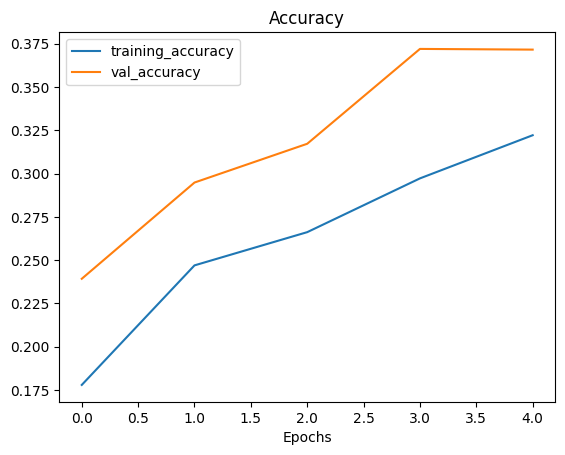

In [ ]:
plot_loss_curves(history_8)

In [ ]:
!wget -q https://www.heinens.com/content/uploads/2023/06/Tuna-Sushi-Rolls-800x550-1.jpg
!wget -q https://www.aspicyperspective.com/wp-content/uploads/2020/05/Best-Hamburger-Patty-Recipe-14-650x882.jpg
!wget -q https://alexandracooks.com/wp-content/uploads/2019/09/chickencurrywithspinach_alexandraskitchen.jpg

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


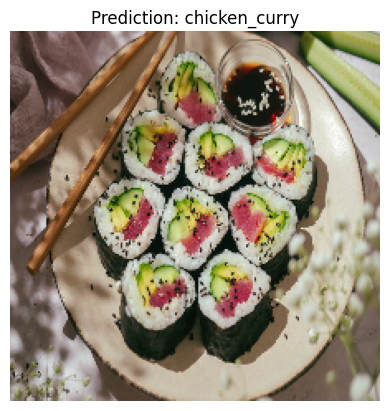

In [ ]:
class_names = ['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi']

pred_and_plot(model=model_8,
              filename="Tuna-Sushi-Rolls-800x550-1.jpg",
              class_names=class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


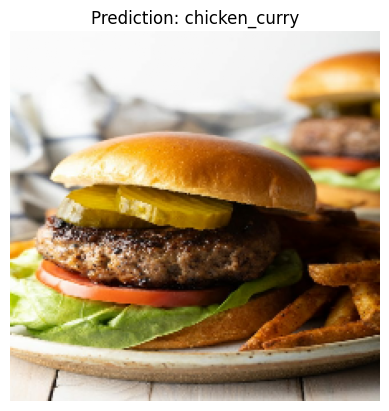

In [ ]:
pred_and_plot(model_8, "Best-Hamburger-Patty-Recipe-14-650x882.jpg", class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


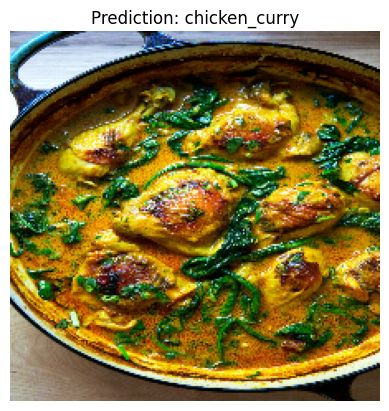

In [ ]:
pred_and_plot(model_8, "chickencurrywithspinach_alexandraskitchen.jpg", class_names)

In [ ]:
model_8.save("saved_trained_model.keras")

In [ ]:
loaded_model = tf.keras.models.load_model("saved_trained_model.keras")
loaded_model.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 170ms/step - accuracy: 0.3746 - loss: 1.8416


[1.8317813873291016, 0.3716000020503998]

🚨 **Room for Improvement:**

Despite the improvements, our model’s predictions are still far from ideal, achieving only ~32% accuracy on the test dataset. To further enhance performance, we will leverage transfer learning by utilizing pre-trained models trained on massive datasets. This should help our model learn more robust and meaningful features, significantly improving classification accuracy.

### 🚀 **Next Steps:**
🔹 Try fine-tuning a pre-trained model like MobileNetV2 or ResNet50.

🔹 Experiment with batch normalization and dropout layers to reduce overfitting.

🔹 Increase training epochs while using learning rate scheduling.